In [1]:
# Import necessary libraries:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress warnings to reduce unnecessary output:
warnings.filterwarnings("ignore")

# Import entire module and use the module name to access functions:
from project_functions import initial_exploration, data_cleaning, eda

# Assign shorthand references to the modules:
explo = initial_exploration
cl = data_cleaning
eda = eda

# Enable auto-reload for module reloading during development
%load_ext autoreload
%autoreload 2

# Set display options for Pandas to show all columns
pd.set_option('display.max_columns', None)


In [2]:
# Load datasets for cash requests and fees:
cash_requests = pd.read_csv('project_dataset/extract - cash request - data analyst.csv')
fees = pd.read_csv('project_dataset/extract - fees - data analyst - .csv')

In [3]:
# Display first few rows of the cash requests data:
cash_requests.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
1,70,100.0,rejected,2019-12-10 19:50:12.34778+00,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
2,7,100.0,rejected,2019-12-10 19:13:35.82546+00,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
3,10,99.0,rejected,2019-12-10 19:16:10.880172+00,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
4,1594,100.0,rejected,2020-05-06 09:59:38.877376+00,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN


In [4]:
# Perform initial exploration on cash requests data:
explo.check(cash_requests)


Number of columns: 16 amd rows: 23970

Data types:
id                              int64
amount                        float64
status                         object
created_at                     object
updated_at                     object
user_id                       float64
moderated_at                   object
deleted_account_id            float64
reimbursement_date             object
cash_request_received_date     object
money_back_date                object
transfer_type                  object
send_at                        object
recovery_status                object
reco_creation                  object
reco_last_update               object
dtype: object

Unique values count:
id                            23970
amount                           41
status                            7
created_at                    23970
updated_at                    23970
user_id                       10798
moderated_at                  16035
deleted_account_id             1141
reimbursement_dat

In [5]:
# Convert date columns to correct datetime format:
cl.convert_dates(cash_requests, cl.cash_request_date_columns)

# Recheck data after converting date columns to ensure they are in correct format:
cash_requests.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,2019-12-10,2019-12-11,804.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT
1,70,100.0,rejected,2019-12-10,2019-12-11,231.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT
2,7,100.0,rejected,2019-12-10,2019-12-11,191.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT
3,10,99.0,rejected,2019-12-10,2019-12-18,761.0,2019-12-18,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT
4,1594,100.0,rejected,2020-05-06,2020-05-07,7686.0,2020-05-07,NaN,2020-06-05,NaT,NaT,regular,NaT,NaN,NaT,NaT


In [6]:
# Ensure correct data types for the columns in cash requests data:
cl.ensure_correct_data_types(cash_requests, cl.cash_request_date_columns)

# Re-check data to ensure the correct types have been applied:
explo.check(cash_requests)

Number of columns: 16 amd rows: 23970

Data types:
id                                     int64
amount                               float64
status                              category
created_at                    datetime64[ns]
updated_at                    datetime64[ns]
user_id                              float64
moderated_at                  datetime64[ns]
deleted_account_id                   float64
reimbursement_date            datetime64[ns]
cash_request_received_date    datetime64[ns]
money_back_date               datetime64[ns]
transfer_type                       category
send_at                       datetime64[ns]
recovery_status                     category
reco_creation                 datetime64[ns]
reco_last_update              datetime64[ns]
dtype: object

Unique values count:
id                            23970
amount                           41
status                            7
created_at                      330
updated_at                      401
user_id      

In [7]:
# Perform initial exploration on fees data:
fees.head()

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,NaN,NaN,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,NaN,NaN,after


In [8]:
explo.check(fees)

Number of columns: 13 amd rows: 21061

Data types:
id                   int64
cash_request_id    float64
type                object
status              object
category            object
total_amount       float64
reason              object
created_at          object
updated_at          object
paid_at             object
from_date           object
to_date             object
charge_moment       object
dtype: object

Unique values count:
id                 21061
cash_request_id    12933
type                   3
status                 4
category               2
total_amount           2
reason             15149
created_at         21026
updated_at         21061
paid_at            15529
from_date           1084
to_date             1560
charge_moment          2
dtype: int64

This columns apear to be categroical:
 Index(['type', 'status', 'category', 'total_amount', 'charge_moment'], dtype='object')

Unique value count for categorical columns:
type
instant_payment    11099
postpone            77

In [9]:
# Convert date columns in the fees data to correct datetime format:
cl.convert_dates(fees, cl.fees_data_date_columns)

# Recheck fees data after converting date columns:
fees.head()


,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07,2020-10-13,2020-12-17,NaT,NaT,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09,2020-10-13,2020-12-08,NaT,NaT,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23,2020-10-23,2020-11-04,NaT,NaT,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31,2020-10-31,2020-11-19,NaT,NaT,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06,2020-10-13,2020-11-02,NaT,NaT,after


In [10]:
# Ensure correct data types for columns in fees data:
cl.ensure_correct_data_types(fees, cl.fees_data_date_columns)

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07,2020-10-13,2020-12-17,NaT,NaT,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09,2020-10-13,2020-12-08,NaT,NaT,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23,2020-10-23,2020-11-04,NaT,NaT,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31,2020-10-31,2020-11-19,NaT,NaT,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06,2020-10-13,2020-11-02,NaT,NaT,after
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21056,12372,20262.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 20262,2020-10-10,2020-10-13,2020-11-17,NaT,NaT,after
21057,20768,26764.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 26764,2020-10-31,2020-10-31,2020-12-16,NaT,NaT,after
21058,18779,25331.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 25331,2020-10-27,2020-10-27,2020-11-18,NaT,NaT,after
21059,16542,23628.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 23628,2020-10-23,2020-10-23,2020-12-18,NaT,NaT,after


In [11]:
# Rename 'id' column in cash requests dataset to 'cash_request_id' for clarity:
cash_requests = cl.rename_col(cash_requests, 'id', 'cash_request_id')

# Merge cash requests and fees data frames on 'cash_request_id':
data_df = cl.merge_df(cash_requests, fees, 'outer', 'cash_request_id')

# Rename columns that have the same name in both data frames to avoid conflicts:
data_df = cl.rename_col_xy(data_df)

# Rename 'id' column in the merged data to 'id_fee' for clarity:
data_df = cl.rename_col(data_df, 'id', 'id_fee')


In [12]:
# Clean text in 'reason' column to standardize it:
cl.clean_text_column(data_df, "reason")

# Remove rows with NaN values in 'cash_request_id' column:
data_df = cl.remove_nan(data_df, "amount")

# Drop unnecessary columns such as 'id_fee' and 'category':
data_df = cl.drop_col(data_df, ["id_fee", "category"])

# Display cleaned data:
data_df.head(10)


4 rows were removed



,cash_request_id,amount,CR_status,CR_created_at,CR_updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,type,fee_status,total_amount,reason,fee_created_at,fee_updated_at,paid_at,from_date,to_date,charge_moment
0,5.0,100.0,rejected,2019-12-10,2019-12-11,804.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
1,70.0,100.0,rejected,2019-12-10,2019-12-11,231.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
2,7.0,100.0,rejected,2019-12-10,2019-12-11,191.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
3,10.0,99.0,rejected,2019-12-10,2019-12-18,761.0,2019-12-18,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
4,1594.0,100.0,rejected,2020-05-06,2020-05-07,7686.0,2020-05-07,NaN,2020-06-05,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
5,2145.0,100.0,money_back,2020-05-23,2020-07-06,9489.0,2020-05-24,NaN,2020-06-06,2020-05-26,2020-07-06,regular,NaT,completed,2020-06-12,2020-07-06,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
6,3512.0,100.0,rejected,2020-06-16,2020-06-17,14631.0,2020-06-17,NaN,2020-07-11,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
7,654.0,100.0,rejected,2020-02-10,2020-02-10,NaN,2020-02-10,309.0,2020-03-11,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
8,5672.0,100.0,canceled,2020-06-28,2020-06-28,NaN,NaT,2499.0,2020-07-07,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
9,71.0,90.0,rejected,2019-12-10,2019-12-12,897.0,2019-12-12,NaN,2019-12-17,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN


In [13]:
# Split cleaned dataset into numerical, categorical, and date-based frames:
frames = cl.selecting_data_types(data_df)
num = frames[1]
cat = frames[0]
date = frames[2]



In [14]:
# Display numerical data and check for null values:
num.head()


,amount,user_id
0,100.0,804.0
1,100.0,231.0
2,100.0,191.0
3,99.0,761.0
4,100.0,7686.0


In [15]:
# Display categorical data and check for null values:
cat.head()

,CR_status,transfer_type,recovery_status,type,fee_status,reason,charge_moment,total_amount
0,rejected,regular,NaN,NaN,NaN,NaN,NaN,NaN
1,rejected,regular,NaN,NaN,NaN,NaN,NaN,NaN
2,rejected,regular,NaN,NaN,NaN,NaN,NaN,NaN
3,rejected,regular,NaN,NaN,NaN,NaN,NaN,NaN
4,rejected,regular,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Display date data and check for null values:
date.head()

,CR_created_at,CR_updated_at,moderated_at,reimbursement_date,cash_request_received_date,money_back_date,send_at,reco_creation,reco_last_update,fee_created_at,fee_updated_at,paid_at,from_date,to_date
0,2019-12-10,2019-12-11,2019-12-11,2020-01-09,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2019-12-10,2019-12-11,2019-12-11,2020-01-09,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-12-10,2019-12-11,2019-12-11,2020-01-09,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-12-10,2019-12-18,2019-12-18,2020-01-09,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2020-05-06,2020-05-07,2020-05-07,2020-06-05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [17]:
# Verify data types of the date columns in the cash requests dataset:
print("\nCheck data types of date columns:")
print(cash_requests[['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 
                     'cash_request_received_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']].dtypes)

# Check for any missing values (NaT) in the date columns:
print("\nCheck NaT (missing values) in date columns:")
print(cash_requests[['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 
                     'cash_request_received_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']].isna().sum())



Check data types of date columns:
created_at                    datetime64[ns]
updated_at                    datetime64[ns]
moderated_at                  datetime64[ns]
reimbursement_date            datetime64[ns]
cash_request_received_date    datetime64[ns]
money_back_date               datetime64[ns]
send_at                       datetime64[ns]
reco_creation                 datetime64[ns]
reco_last_update              datetime64[ns]
dtype: object

Check NaT (missing values) in date columns:
created_at                        0
updated_at                        0
moderated_at                   7935
reimbursement_date                0
cash_request_received_date     7681
money_back_date                7427
send_at                        7504
reco_creation                 20640
reco_last_update              20640
dtype: int64


In [18]:
# Total amount should be numerical so we are moving it from cat to num
cat, num = cl.move_column(cat, num, "total_amount")

#Let's check cat again
cat.head()

,CR_status,transfer_type,recovery_status,type,fee_status,reason,charge_moment
0,rejected,regular,NaN,NaN,NaN,NaN,NaN
1,rejected,regular,NaN,NaN,NaN,NaN,NaN
2,rejected,regular,NaN,NaN,NaN,NaN,NaN
3,rejected,regular,NaN,NaN,NaN,NaN,NaN
4,rejected,regular,NaN,NaN,NaN,NaN,NaN


In [19]:
# Setting CR created at as index for the cohort analysis 
cat = cl.set_index(cat, data_df, 'CR_created_at')

#Let's check cat again
cat.head()

,CR_status,transfer_type,recovery_status,type,fee_status,reason,charge_moment
CR_created_at,,,,,,,
2019-12-10,rejected,regular,NaN,NaN,NaN,NaN,NaN
2019-12-10,rejected,regular,NaN,NaN,NaN,NaN,NaN
2019-12-10,rejected,regular,NaN,NaN,NaN,NaN,NaN
2019-12-10,rejected,regular,NaN,NaN,NaN,NaN,NaN
2020-05-06,rejected,regular,NaN,NaN,NaN,NaN,NaN


In [20]:
# Look to numerical columns
num.head()

,amount,user_id,total_amount
0,100.0,804.0,NaN
1,100.0,231.0,NaN
2,100.0,191.0,NaN
3,99.0,761.0,NaN
4,100.0,7686.0,NaN


In [21]:
# Lets add more data to the numerical data frame using the dates column

# Time between a CR is created and Ironhack get the mnoney back
df_time_between_CR_and_money_back = cl.process_date_columns(date, "CR_created_at", "money_back_date", "days_difference_CR_back")
num = cl.merge_by_index(num, df_time_between_CR_and_money_back, "outer", "days_difference_CR_back")

# Time between a fee timestamp is created and Ironhack get the mnoney
df_time_between_fee_created_and_paid_at_date = cl.process_date_columns(date, "fee_created_at", "paid_at", "days_difference_fee_paid")
num = cl.merge_by_index(num, df_time_between_fee_created_and_paid_at_date, "outer", "days_difference_fee_paid")


# A new look to numerical data frame
num.head(10)


,amount,user_id,total_amount,days_difference_CR_back,days_difference_fee_paid
0,100.0,804.0,NaN,NaN,NaN
1,100.0,231.0,NaN,NaN,NaN
2,100.0,191.0,NaN,NaN,NaN
3,99.0,761.0,NaN,NaN,NaN
4,100.0,7686.0,NaN,NaN,NaN
5,100.0,9489.0,NaN,44.0,NaN
6,100.0,14631.0,NaN,NaN,NaN
7,100.0,NaN,NaN,NaN,NaN
8,100.0,NaN,NaN,NaN,NaN
9,90.0,897.0,NaN,NaN,NaN


In [22]:
# Setting CR created at as index for the cohort analysis 
num = cl.set_index(num, data_df, 'CR_created_at')

# A new look to numerical data frame
num_copy = num.copy()
num.head(10)

,amount,user_id,total_amount,days_difference_CR_back,days_difference_fee_paid
CR_created_at,,,,,
2019-12-10,100.0,804.0,NaN,NaN,NaN
2019-12-10,100.0,231.0,NaN,NaN,NaN
2019-12-10,100.0,191.0,NaN,NaN,NaN
2019-12-10,99.0,761.0,NaN,NaN,NaN
2020-05-06,100.0,7686.0,NaN,NaN,NaN
2020-05-23,100.0,9489.0,NaN,44.0,NaN
2020-06-16,100.0,14631.0,NaN,NaN,NaN
2020-02-10,100.0,NaN,NaN,NaN,NaN
2020-06-28,100.0,NaN,NaN,NaN,NaN


transfer_type
         absolute_frequency  relative_frequency
instant               19488               0.607
regular               12606               0.393
Total                 32094               1.000


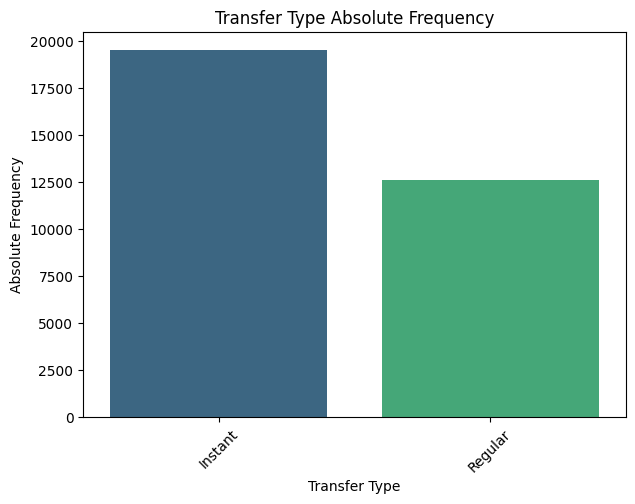

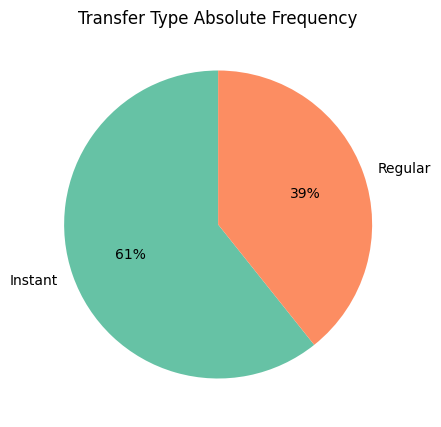


type
                 absolute_frequency  relative_frequency
instant_payment               11095               0.527
postpone                       7766               0.369
incident                       2196               0.104
Total                         21057               1.000


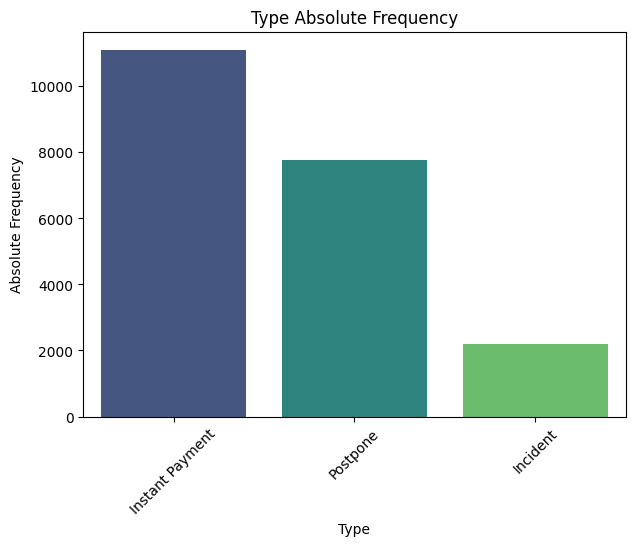

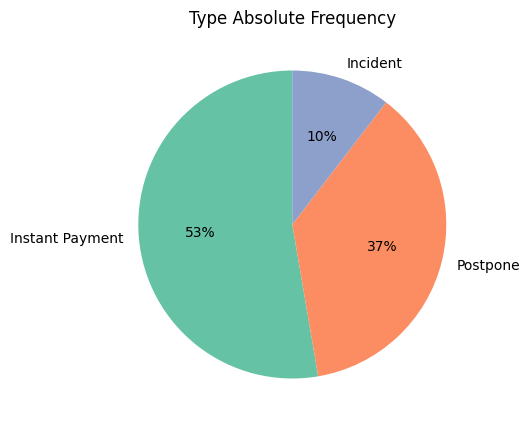

In [23]:
# Generate frequency table and bar plots for category columns
for column in cat.columns[1:4:2]:
    print(column)
    df0, df1 = eda.freq(cat, column)
    print(df0)
    eda.cat_viz(cat, df1, column)
    print("")

amount
count    32094.000000
mean        83.516514
std         25.900244
min          1.000000
25%         50.000000
50%        100.000000
75%        100.000000
max        200.000000
Name: amount, dtype: float64


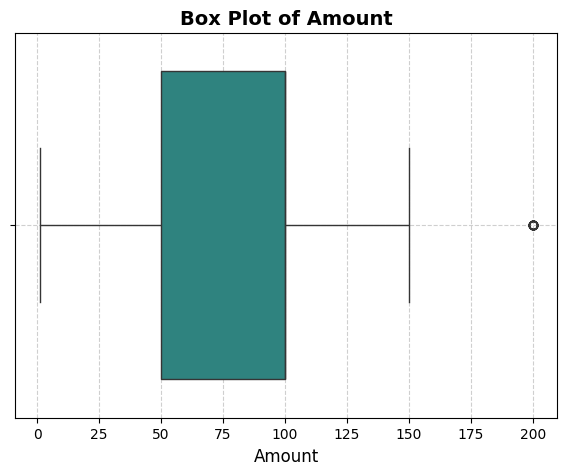

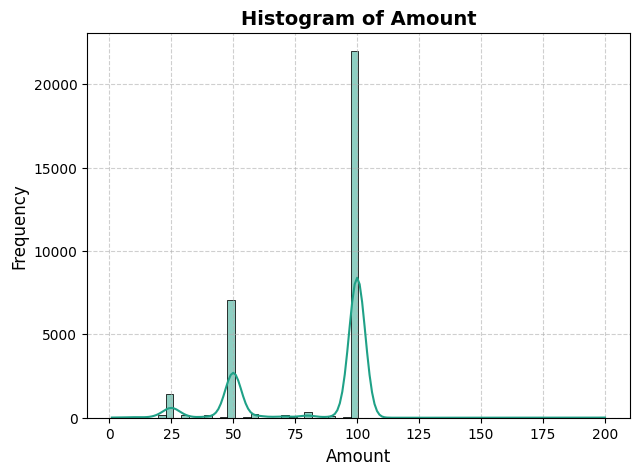


total_amount
count    21057.000000
mean         5.000237
std          0.034457
min          5.000000
25%          5.000000
50%          5.000000
75%          5.000000
max         10.000000
Name: total_amount, dtype: float64


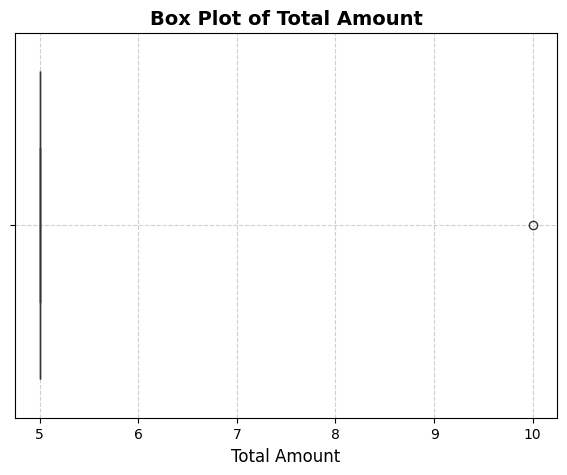

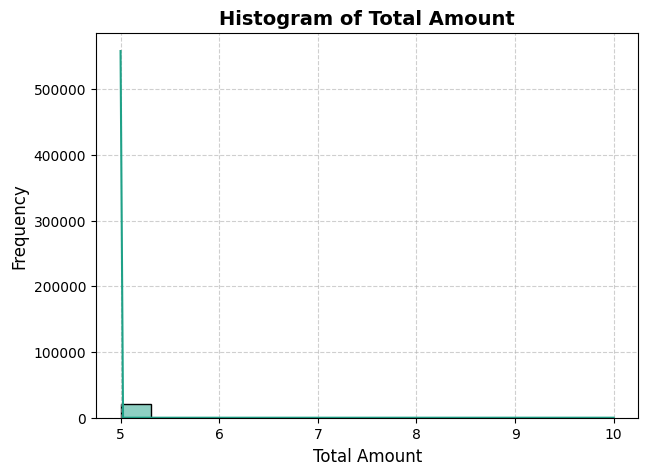

In [24]:
# EDA for numerical columns
for column in num.columns[0:4:2]:
    print(column)
    print(eda.stat(num, column))
    eda.stat_viz(num,column)
    print("")

In [25]:
# Create 'first_advance_date' column for each user, representing the first cash request created date:
data_df['first_advance_date'] = data_df.groupby('user_id')['CR_created_at'].transform('min')

# Create 'cohort_month' column that groups users based on their first transaction month:
data_df['cohort_month'] = data_df['first_advance_date'].dt.to_period('M')

# Calculate 'cohort_index' to represent number of months since the user's first transaction:
data_df['cohort_index'] = (data_df['CR_created_at'].dt.year - data_df['first_advance_date'].dt.year) * 12 + \
                          (data_df['CR_created_at'].dt.month - data_df['first_advance_date'].dt.month) + 1

# Display data frame info to confirm the cohort columns exist:
print(data_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 32094 entries, 0 to 32093
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cash_request_id             32094 non-null  float64       
 1   amount                      32094 non-null  float64       
 2   CR_status                   32094 non-null  category      
 3   CR_created_at               32094 non-null  datetime64[ns]
 4   CR_updated_at               32094 non-null  datetime64[ns]
 5   user_id                     29522 non-null  float64       
 6   moderated_at                21759 non-null  datetime64[ns]
 7   deleted_account_id          2573 non-null   float64       
 8   reimbursement_date          32094 non-null  datetime64[ns]
 9   cash_request_received_date  24149 non-null  datetime64[ns]
 10  money_back_date             23917 non-null  datetime64[ns]
 11  transfer_type               32094 non-null  category      


In [26]:
# Group by 'cohort_month' and count number of users in each cohort:
data_df.groupby('cohort_month').size()

# Create cohort table showing the number of users interacting with the service each month:
cohort_table = data_df.groupby(['cohort_month', data_df['CR_created_at'].dt.to_period('M')])['user_id'].count()

# Unstack cohort table to create a matrix with cohorts as rows and months as columns:
cohort_table = cohort_table.unstack()
cohort_table = cohort_table.fillna(0)

# Display cohort table:
print(cohort_table)


CR_created_at  2019-11  2019-12  2020-01  2020-02  2020-03  2020-04  2020-05  \
cohort_month                                                                   
2019-11            1.0      1.0      0.0      0.0      0.0      1.0      5.0   
2019-12            0.0    229.0     75.0     46.0     66.0     66.0     79.0   
2020-01            0.0      0.0    101.0     21.0     15.0     35.0     32.0   
2020-02            0.0      0.0      0.0     90.0     48.0     48.0     57.0   
2020-03            0.0      0.0      0.0      0.0     78.0     39.0     42.0   
2020-04            0.0      0.0      0.0      0.0      0.0    229.0    154.0   
2020-05            0.0      0.0      0.0      0.0      0.0      0.0    509.0   
2020-06            0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2020-07            0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2020-08            0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2020-09            0.0      0.0      0.0

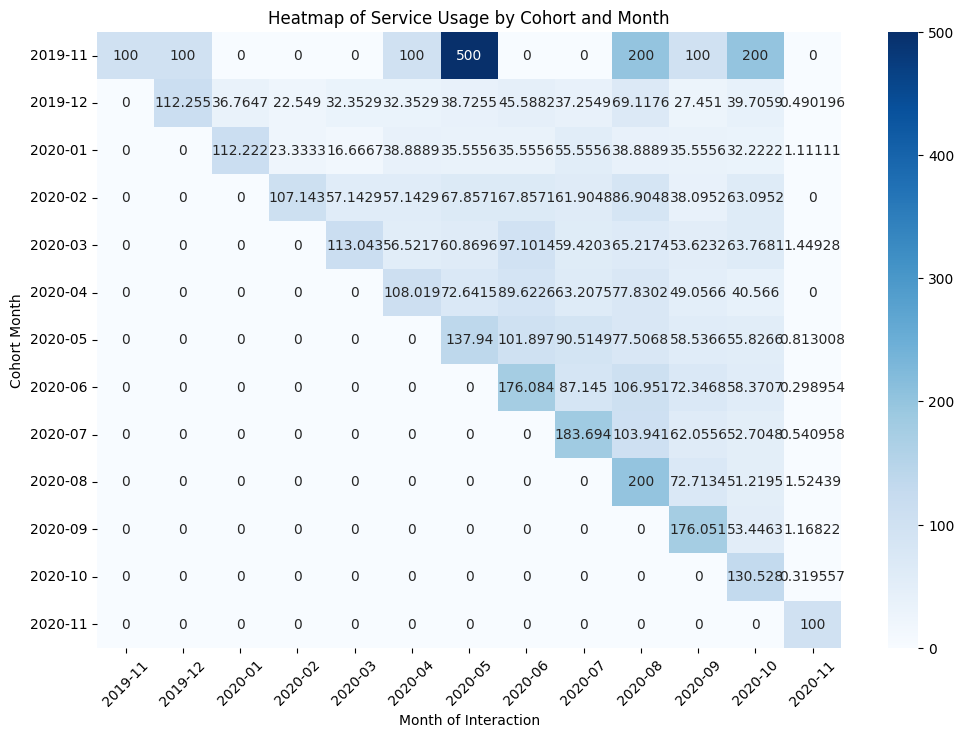

In [27]:
# Calculate frequency of usage for each cohort by dividing usage by cohort size:
cohort_size = data_df.groupby('cohort_month')['user_id'].nunique()
cohort_usage = cohort_table.divide(cohort_size, axis=0) * 100
cohort_usage.fillna(0, inplace=True)

# Plot heatmap of service usage by cohort and month:
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_usage, annot=True, fmt='g', cmap='Blues', cbar=True)
plt.title('Heatmap of Service Usage by Cohort and Month')
plt.xlabel('Month of Interaction')
plt.ylabel('Cohort Month')
plt.xticks(rotation=45)
plt.show()


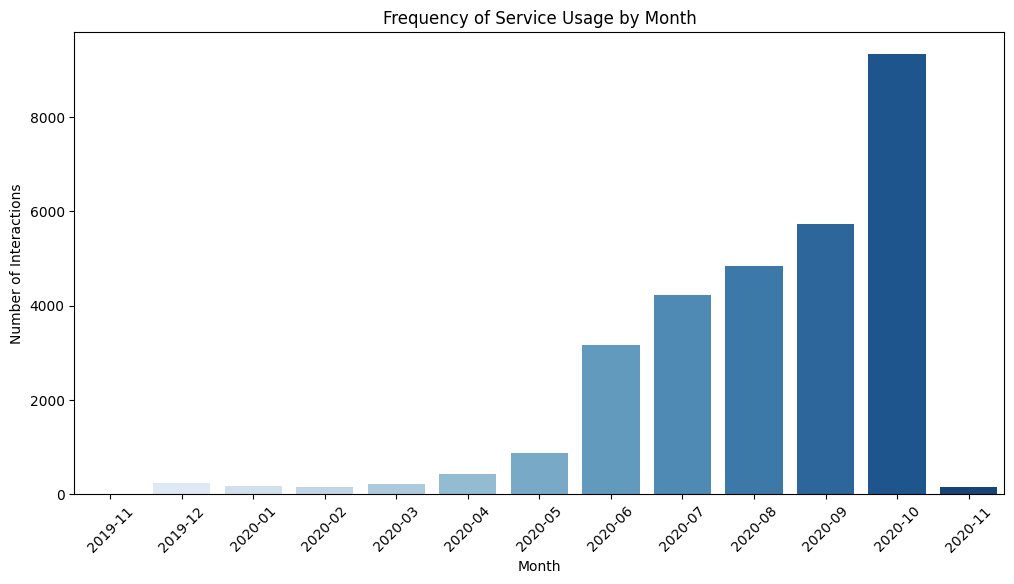

In [28]:
# Plot total frequency of service usage by month:
frequency_by_month = cohort_table.sum(axis=0)
plt.figure(figsize=(12, 6))
sns.barplot(x=frequency_by_month.index.astype(str), y=frequency_by_month.values, palette='Blues')

plt.title('Frequency of Service Usage by Month')
plt.xlabel('Month')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.show()


In [29]:
# Frequency table with absolute counts:
frequency_table = (data_df[data_df['reason'].isin(['rejected direct debit', 'month delay on payment', 'postpone cash request'])]
                   .groupby(['cohort_month', 'reason'])
                   .size()
                   .unstack(fill_value=0))

# Add total column for each cohort month:
frequency_table['Total Incidents'] = frequency_table.sum(axis=1)

# Display table:
print(frequency_table)

reason        month delay on payment  rejected direct debit  Total Incidents
cohort_month                                                                
2019-12                           12                     30               42
2020-01                           10                     11               21
2020-02                            9                     15               24
2020-03                           10                     19               29
2020-04                           49                     64              113
2020-05                           68                    136              204
2020-06                          218                    479              697
2020-07                          164                    378              542
2020-08                           21                    124              145
2020-09                            0                    190              190
2020-10                            0                     23               23

In [30]:
# Define incident reasons of interest:
incident_reasons = ['rejected direct debit', 'month delay on payment']

# Filter data for rows with specific incidents:
incident_data = data_df[data_df['reason'].isin(incident_reasons)]

# Group by cohort month and count unique users with incidents:
incident_counts = incident_data.groupby('cohort_month')['user_id'].nunique()

# Calculate total number of requests for each cohort:
total_requests = data_df.groupby('cohort_month')['user_id'].nunique()

# Calculate incident rate (percentage of incidents per total requests):
incident_rate = (incident_counts / total_requests) * 100

# Round incident rates to two decimal places:
incident_rate_rounded = incident_rate.round()

# Display incident rate by cohort:
print(incident_rate_rounded)


cohort_month
2019-11     NaN
2019-12    13.0
2020-01    10.0
2020-02    15.0
2020-03    23.0
2020-04    23.0
2020-05    29.0
2020-06    30.0
2020-07    26.0
2020-08    19.0
2020-09    11.0
2020-10     0.0
2020-11     NaN
Freq: M, Name: user_id, dtype: float64


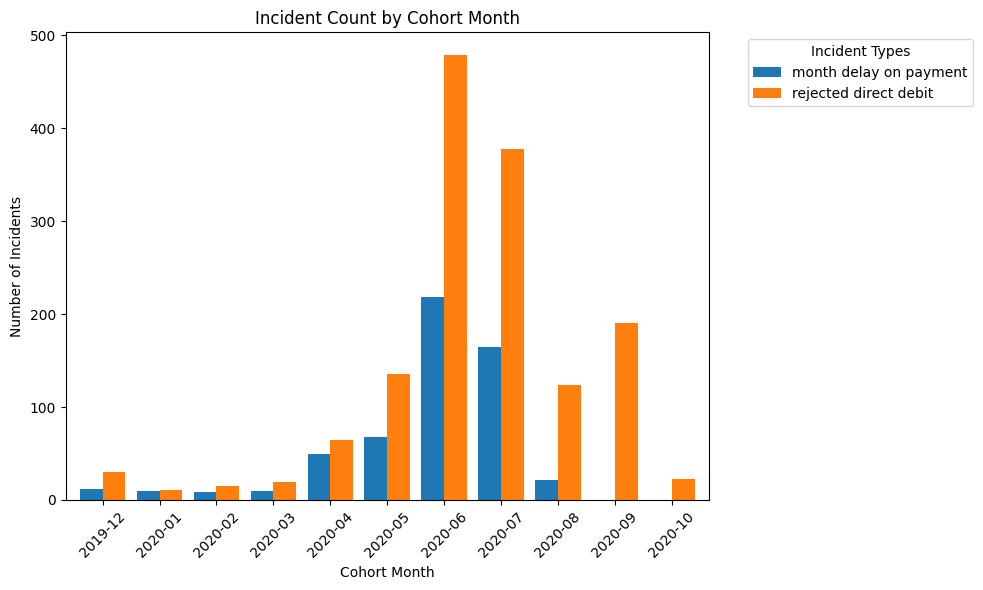

In [31]:
# Filter only relevant incidents:
incident_counts = (data_df[data_df['reason'].isin(['rejected direct debit', 'month delay on payment', 'postpone cash request'])]
                   .groupby(['cohort_month', 'reason'])
                   .size()
                   .unstack(fill_value=0))

# Plot grouped bar chart:
incident_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

# Labels and formatting:
plt.title('Incident Count by Cohort Month')
plt.ylabel('Number of Incidents')
plt.xlabel('Cohort Month')
plt.xticks(rotation=45)
plt.legend(title="Incident Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

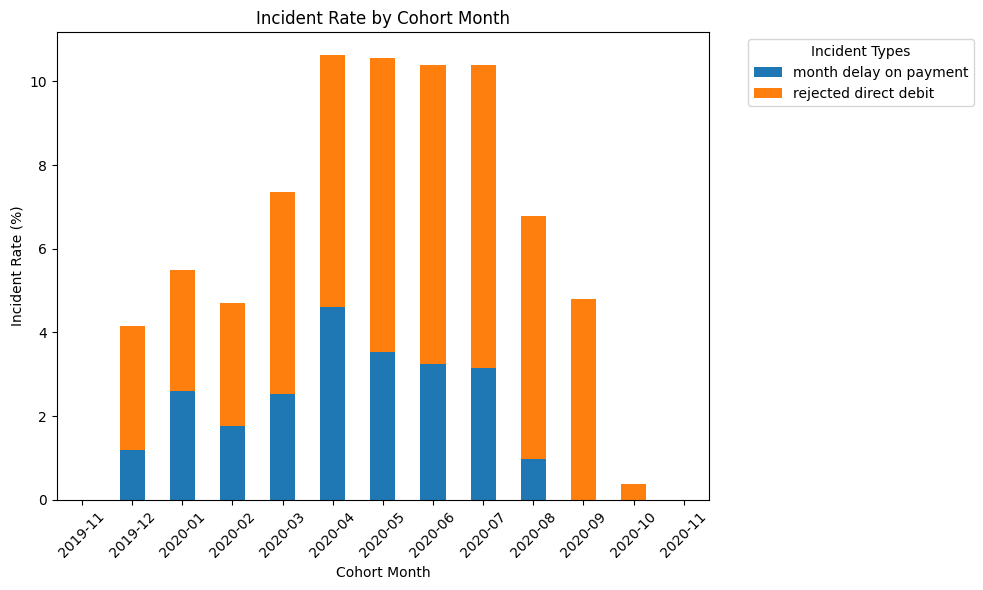

In [32]:
# Filter only relevant incidents:
incident_counts = (data_df[data_df['reason'].isin(['rejected direct debit', 'month delay on payment', 'postpone cash request'])]
                   .groupby(['cohort_month', 'reason'])
                   .size()
                   .unstack(fill_value=0))

# Total requests per cohort:
total_requests = data_df.groupby('cohort_month').size()

# Calculate incident rate as a percentage:
incident_rate = (incident_counts.div(total_requests, axis=0) * 100)

# Plot stacked bar chart:
incident_rate.plot(kind='bar', stacked=True, figsize=(10, 6))

# Labels and formatting:
plt.title('Incident Rate by Cohort Month')
plt.ylabel('Incident Rate (%)')
plt.xlabel('Cohort Month')
plt.xticks(rotation=45)
plt.legend(title="Incident Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [33]:
#Copy of numerical data frame
num_r = num_copy.copy()

# Revenue Generated by the Cohort: Calculate the total revenue generated by each cohort over months to assess the financial impact of user behavior.
revenue = eda.revenue_metric(num_r, "total_amount")

# Let's have a look to the revenue table
revenue

,total_amount,percentage
cohort_month,,
2019-11,0.0,0.0
2019-12,0.0,0.0
2020-01,0.0,0.0
2020-02,0.0,0.0
2020-03,0.0,0.0
2020-04,5.0,0.0
2020-05,1285.0,1.22
2020-06,8725.0,8.29
2020-07,10395.0,9.87


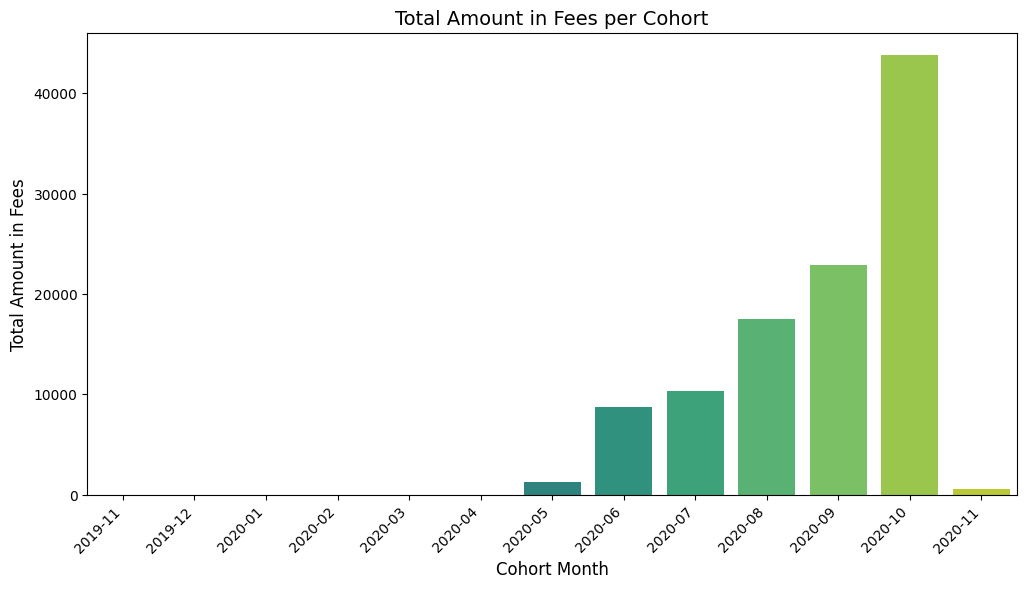

<Figure size 640x480 with 0 Axes>

In [34]:
# Let's plot the total revenue per month
eda.revenue_plot(revenue)

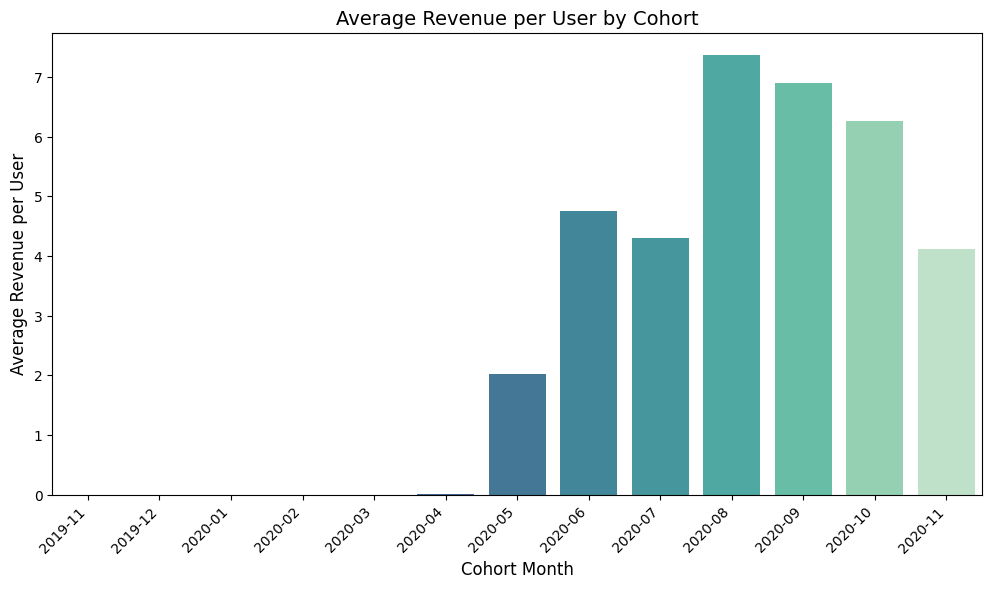

<Figure size 640x480 with 0 Axes>

In [35]:
cohort_data = eda.revenue_plot_per_user(num_r)

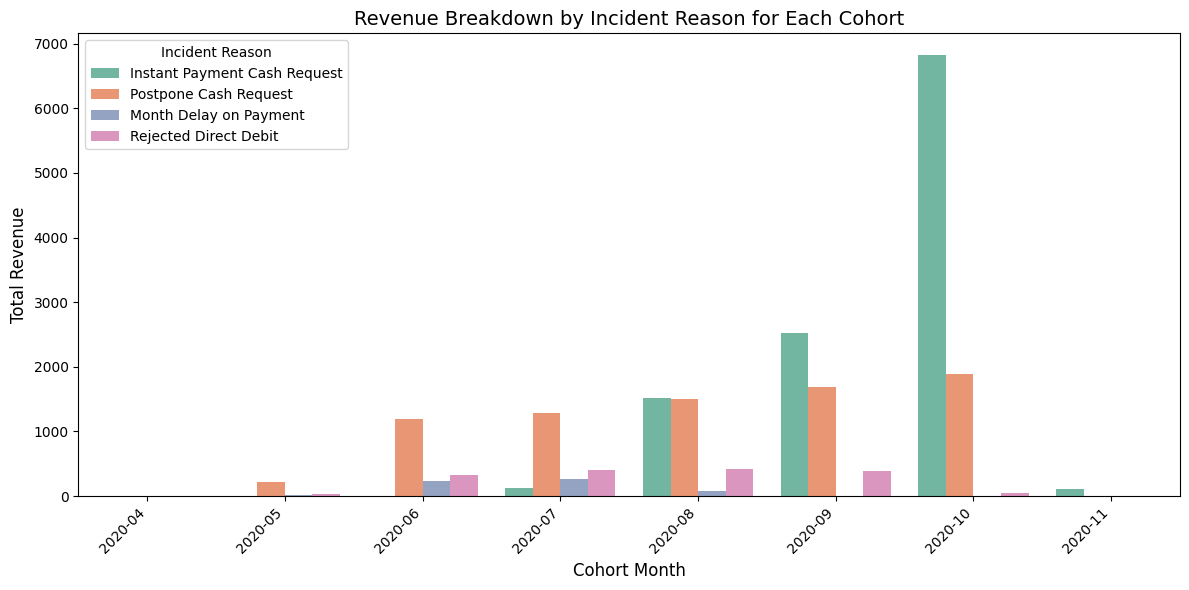

,cohort_month,total_fees,Instant Payment Cash Request,Postpone Cash Request,Month Delay on Payment,Rejected Direct Debit
0,2020-04,5.0,0,1,0,0
1,2020-05,1285.0,0,213,14,30
2,2020-06,8725.0,0,1185,237,323
3,2020-07,10395.0,127,1293,261,398
4,2020-08,17565.0,1515,1500,85,413
5,2020-09,22935.0,2521,1681,0,385
6,2020-10,43815.0,6819,1893,0,50
7,2020-11,565.0,113,0,0,0


<Figure size 640x480 with 0 Axes>

In [36]:
#Let's make a copy of the data for the bivariate analysis
cat_new = cat.copy()
num_new = cohort_data.copy()

# Corelation between the diferent incidents and the revenue  
df_merged, df_melted = eda.bi_rev_incid(cat_new, num_new)
df_merged

In [37]:
# Lets restructure the data
cat_new = cat.copy()
num_new = num_r.copy()
new_data_str = eda.restruct(cat_new, num_new)
new_data_str[2]

total_amount                                  \
cohort_month                      2020-04 2020-05 2020-06 2020-07 2020-08   
reason                                                                      
Instant Payment Cash Request          0.0     0.0     0.0    35.0   155.0   
Postpone Cash Request                 5.0   115.0   150.0   155.0   155.0   
month delay on payment                0.0    35.0   140.0   155.0   130.0   
rejected direct debit                 0.0    70.0   150.0   155.0   155.0   

                                                          
cohort_month                 2020-09     2020-10 2020-11  
reason                                                    
Instant Payment Cash Request   150.0  155.015974     5.0  
Postpone Cash Request          150.0  155.015974     0.0  
month delay on payment           0.0    0.000000     0.0  
rejected direct debit          150.0   85.000000     0.0